# Afriat

In [1]:
import warnings
import os
import sys
import gc

In [2]:
import warnings
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import tqdm
import scipy.stats
import sklearn
from sklearn.dummy import DummyClassifier

sys.path.append("/home/icb/kemal.inecik/work/codes/tardis")
import tardis
from tardis._utils.functions import label_transfer
from tardis._utils.warnings import suppress_stdout, ignore_predetermined_warnings
tardis.config = tardis.config_server
print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False


In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [4]:
num_ood = 1  # not functioning

In [5]:
def get_availables():
    adata_file_path = os.path.join(tardis.config.io_directories["processed"], "dataset_complete_Miller.h5ad")
    assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
    adata = ad.read_h5ad(adata_file_path)
    adata.obs["age"] = adata.obs["age"].astype("str").astype("category")
    
    adata.obs["age"] = adata.obs["age"].astype("str").astype("category")
    adata.obs["age_continuous"] = adata.obs["age"].astype(float)
    df = adata.obs.groupby(["cell_type", "age"]).size()
    df2 = adata.obs.groupby(["cell_type"]).size()
    availables = [(i, df[i]) for i in df.index if df[i] > 100 and df2[i[0]] > 350]
    return availables

In [8]:
def get_classification(ood_seed, target_obs):
    with warnings.catch_warnings(), suppress_stdout():
        warnings.simplefilter("ignore")
        adata_file_path = os.path.join(tardis.config.io_directories["processed"], "dataset_complete_Miller.h5ad")
        assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
        adata = ad.read_h5ad(adata_file_path)
        adata.obs["age"] = adata.obs["age"].astype("str").astype("category")
        
        adata.obs["age"] = adata.obs["age"].astype("str").astype("category")
        adata.obs["age_continuous"] = adata.obs["age"].astype(float)
        df = adata.obs.groupby(["cell_type", "age"]).size()
        df2 = adata.obs.groupby(["cell_type"]).size()
        availables = [(i, df[i]) for i in df.index if df[i] > 100 and df2[i[0]] > 350]
        
        def adata_ood_creator(adata, seed, size):
            rng = np.random.default_rng(seed=seed)
            # random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
            # choices = [availables[i] for i in random_choices]
            choices = [availables[ood_seed]]
            choices_bool = np.vstack([(adata.obs["cell_type"] == choice[0][0]) & (adata.obs["age"] == choice[0][1]) for choice in choices]).any(axis=0)
            return adata[~choices_bool, :].copy(), choices_bool, choices[0][0]
        
        adata, choices_bool, choice = adata_ood_creator(adata, seed=ood_seed, size=num_ood)
    
        dir_path = os.path.join(
            tardis.config.io_directories["models"],
            f"miller_ood-seed-{ood_seed}_size-{num_ood}_obs-{target_obs}"
        )
        vae = tardis.MyModel.load(dir_path, adata=adata)
        from tardis._disentanglementmanager import DisentanglementManager as DM
    
        adata_main = ad.read_h5ad(adata_file_path)
        adata_main.obs["age"] = adata_main.obs["age"].astype("str").astype("category")
        adata_main.obs["ood"] = choices_bool.astype(int).astype(str)
        adata_main.obs["ood"] = adata_main.obs["ood"].astype("category")
        adata_ood = adata_main[adata_main.obs["ood"] == "1"].copy()
    
        k = target_obs
        
        latent = ad.AnnData(X=vae.get_latent_representation(adata)[:, DM.configurations.get_by_obs_key(k).reserved_latent_indices], obs=adata.obs.copy())
        sc.pp.neighbors(latent, n_neighbors=90)
        latent_ood = ad.AnnData(X=vae.get_latent_representation(adata_ood)[:, DM.configurations.get_by_obs_key(k).reserved_latent_indices], obs=adata_ood.obs.copy())
        sc.pp.neighbors(latent_ood, n_neighbors=90)
        
        label_transfer(latent, latent_ood, cluster_list=[k], neighbors_count=90)
        predicted = latent_ood.obs[f"transf_{k}"].astype(str).values
        true = latent_ood.obs[k].astype(str).values

        t = latent.obs[k].astype(str).to_numpy().copy()
        dummy_clf = DummyClassifier(strategy="stratified")
        dummy_clf.fit(t.reshape(-1, 1), t)
        dummy_predictions = dummy_clf.predict(t.reshape(-1, 1))
        
        result = {
            "accuracy": sklearn.metrics.accuracy_score(true, predicted), 
            "baseline": sklearn.metrics.accuracy_score(t, dummy_predictions)
        }
        result.update({f"OOD_{i}": choice[ind] for ind, i in enumerate(["cell_type", "age"])})
        return result
        

In [9]:
result = []
for z in ['age', 'integration_donor']:
    for i in tqdm.tqdm(range(len(get_availables())), desc=z):
        d = get_classification(i, z)
        d.update({"target_covariate": z})
        result.append(d)

integration_donor: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [02:44<00:00, 10.30s/it]


In [14]:
df = pd.DataFrame(result)
df

,accuracy,baseline,OOD_cell_type,OOD_age,target_covariate
0,0.721893,0.355445,Bud tip adjacent cells,11.5,age
1,0.464539,0.339604,Bud tip adjacent cells,15.0,age
2,0.805663,0.335094,Bud tip adjacent cells,18.0,age
3,0.421245,0.357123,Bud tip progenitor,11.5,age
4,0.488166,0.331965,Bud tip progenitor,15.0,age
5,0.833089,0.332342,Bud tip progenitor,18.0,age
6,0.536697,0.355642,Hub cells,11.5,age
7,0.402597,0.335494,Hub cells,15.0,age
8,0.600000,0.338246,Hub cells,18.0,age
9,0.758671,0.332936,Lung ciliated cells,15.0,age


<Axes: xlabel='OOD_age', ylabel='accuracy'>

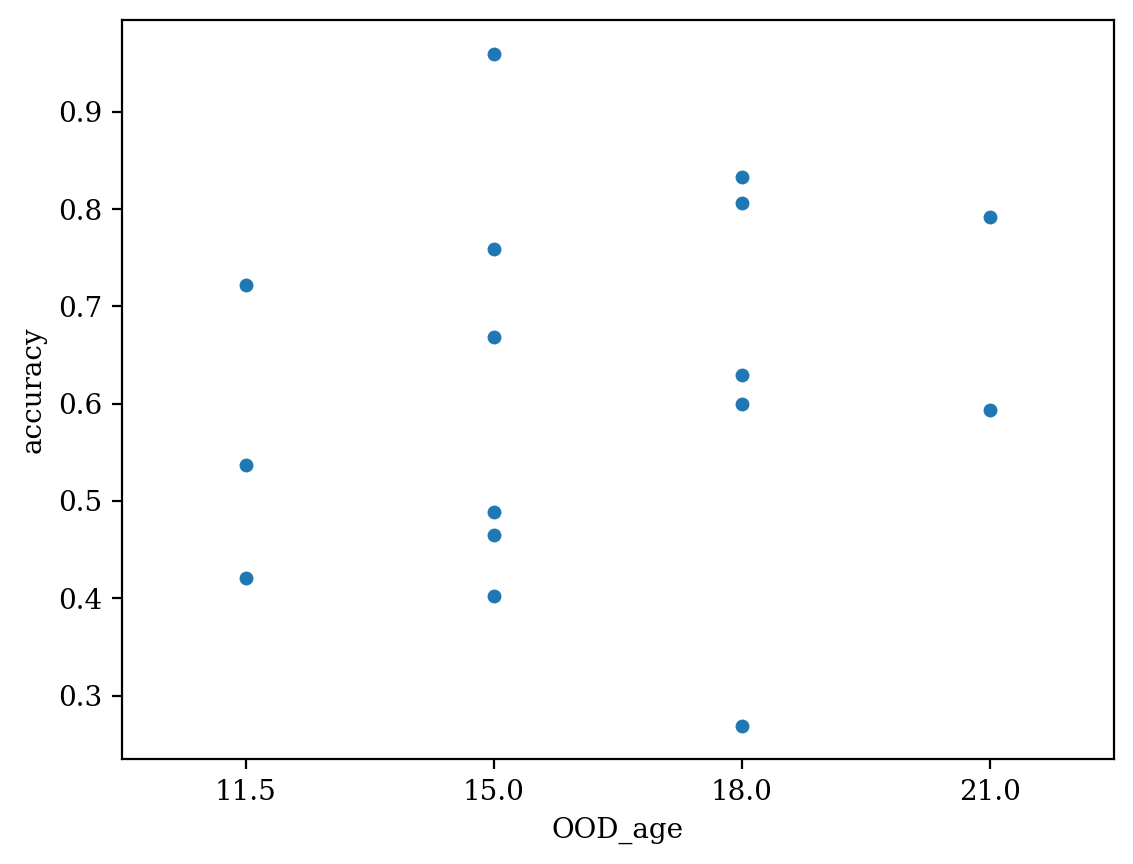

In [20]:
sns.swarmplot(data=df[df["target_covariate"] == "age"], x="OOD_age", y="accuracy")

<Axes: xlabel='target_covariate', ylabel='accuracy'>

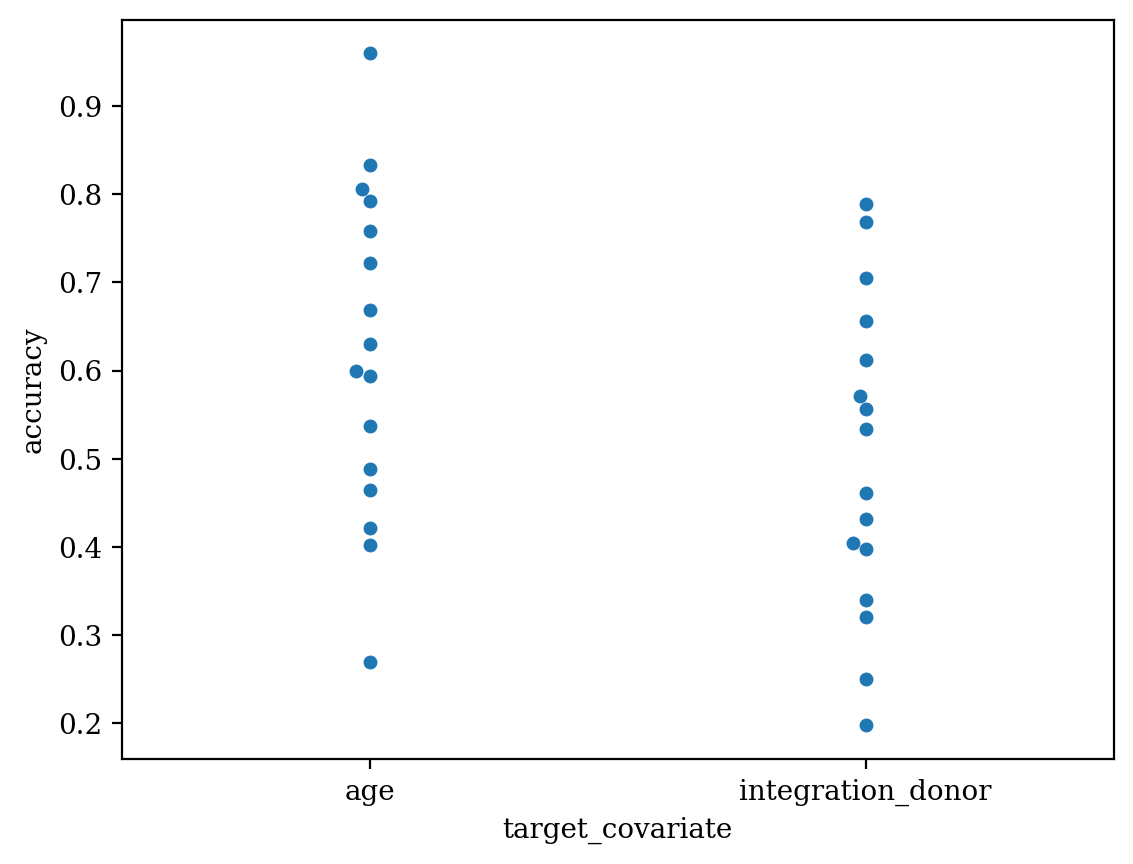

In [21]:
sns.swarmplot(data=df, x="target_covariate", y="accuracy")

In [18]:
df.to_pickle(
    os.path.join(tardis.config.io_directories["processed"], "figures", "figure4_miller_single.pickle")
)